In [193]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])

In [194]:
SAVE_DIR = Path().cwd() # mes/paper_plots
DATA_DIR = Path().cwd().parent / "data" # mes/data
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [269]:
df = pd.read_json(DATA_DIR / "benchmark_df.json")

df["regret"] = df.apply(lambda x: x["y_true_max"] - np.array(x["y_max_history"]), axis=1)
df = df.drop(columns=["y_true_max", "final_y_max", "y_max_history"]) # cleanup rows
df = df.explode(["regret", "steps"], ignore_index=True) # explode history into seperate rows
df["regret"] = pd.to_numeric(df["regret"], errors="raise")

# mean regret over the `n_y` runs
cols2group = [c for c in df.columns if c not in {"run_id", "regret"}]
df = df.groupby(cols2group).mean().drop(columns="run_id").reset_index()
df

,acq_func,kernel_type,len_scale,n_dim,steps,lr,wd,max_iters,regret
0,expected_improvement,matern-3/2,25,2,4,0.001000,0.00,200,1.022589
1,expected_improvement,matern-3/2,25,2,4,0.001000,0.01,200,1.022589
2,expected_improvement,matern-3/2,25,2,4,0.001000,0.10,200,1.022589
3,expected_improvement,matern-3/2,25,2,4,0.001000,1.00,200,1.022589
4,expected_improvement,matern-3/2,25,2,4,0.001000,10.00,200,1.022589
...,...,...,...,...,...,...,...,...,...
5275,ves_gamma,matern-5/2,25,4,25,3.162278,0.00,200,0.775044
5276,ves_gamma,matern-5/2,25,4,25,3.162278,0.01,200,0.183350
5277,ves_gamma,matern-5/2,25,4,25,3.162278,0.10,200,0.183350
5278,ves_gamma,matern-5/2,25,4,25,3.162278,1.00,200,0.183350


Ok this is a bit huge...

Basically what we want to do is find the best config for each `["acq_func", "kernel_type", "n_dim"]`.

Hey did you know you could put a lambda in a `.loc[]` which is the df after all the previous operations? Mine blowing.

In [ ]:
hps_search = (
    df
    .loc[df.steps == df.steps.max()]  # get the last step
    .drop(columns=["steps", "max_iters", "len_scale"])  # drop some boring columns
    # best performing run per config
    .loc[lambda x: x.groupby(["acq_func", "kernel_type", "n_dim"]).regret.idxmin()]
)
hps_search

,acq_func,kernel_type,n_dim,lr,wd,regret
420,expected_improvement,matern-3/2,2,0.001000,0.0,0.007388
860,expected_improvement,matern-3/2,4,0.001000,0.0,0.368674
1300,expected_improvement,matern-5/2,2,0.001000,0.0,0.031762
1740,expected_improvement,matern-5/2,4,0.001000,0.0,0.051742
2180,random_search,matern-3/2,2,0.001000,0.0,0.412350
2620,random_search,matern-3/2,4,0.001000,0.0,0.549059
3060,random_search,matern-5/2,2,0.001000,0.0,0.325915
3500,random_search,matern-5/2,4,0.001000,0.0,0.408777
3944,ves_gamma,matern-3/2,2,0.001000,10.0,0.000000
4395,ves_gamma,matern-3/2,4,3.162278,0.0,0.345687


In [ ]:
tuned_df = hps_search.query("acq_func == 'ves_gamma' and lr == @lr_min and wd == @wd_min and kernel_type == @kernel_type and n_dim == @n_dim")
xfm = tuned_df.groupby([c for c in tuned_df.columns if c != 'regret']).regret.agg(["mean", "count", "std"])

In [292]:
regret_df = df.groupby(['kernel_type', 'n_dim', 'acq_func', 'steps']) # 'lr', 'wd'
regret_df = regret_df['regret'].agg(['mean', 'std', 'count', 'min'])
regret_df # multi-index of key: (kernel_type, n_dim, acq_func, steps)

mean       std  count  \
kernel_type n_dim acq_func             steps                              
matern-3/2  2     expected_improvement 4      1.022589  0.000000     20   
                                       5      0.878841  0.000000     20   
                                       6      0.434619  0.000000     20   
                                       7      0.359082  0.000000     20   
                                       8      0.162858  0.000000     20   
...                                                ...       ...    ...   
matern-5/2  4     ves_gamma            21     0.713007  0.229603     20   
                                       22     0.665448  0.257828     20   
                                       23     0.647067  0.273730     20   
                                       24     0.646486  0.274483     20   
                                       25     0.602524  0.285895     20   

                                                   min  
kernel_type n_dim acq_func             steps            
matern-3/2  2     expected_improvement 4      1.022589  
                                       5      0.878841  
                                       6      0.434619  
                                       7      0.359082  
                                       8      0.162858  
...                                                ...  
matern-5/2  4     ves_gamma            21     0.315195  
                                       22     0.298037  
                                       23     0.247433  
                                       24     0.247433  
                                       25     0.183350  

[264 rows x 4 columns]

In [114]:
regret_df.index.get_level_values("acq_func").unique()

Index(['expected_improvement', 'random_search', 'ves_gamma'], dtype='object', name='acq_func')

This gives us a multi-index dataframe with unique keys of `(kernel_type, n_dim, acq_func, steps)` and mean, std, count regret for each row.

To index into a single kernel / dimension, we can use:

In [115]:
regret_df.loc[('matern-3/2', 4)]

mean       std  count       min
acq_func             steps                                     
expected_improvement 4      1.400413  0.000000     20  1.400413
                     5      1.355531  0.000000     20  1.355531
                     6      1.341878  0.000000     20  1.341878
                     7      1.292087  0.000000     20  1.292087
                     8      1.038795  0.000000     20  1.038795
...                              ...       ...    ...       ...
ves_gamma            21     0.711111  0.101535     20  0.454692
                     22     0.689365  0.115635     20  0.393795
                     23     0.639186  0.098204     20  0.393795
                     24     0.609832  0.109239     20  0.368604
                     25     0.590069  0.102863     20  0.345687

[66 rows x 4 columns]

/Users/tomp/work/mes/paper_plots/benchmark-matern-3_2.png


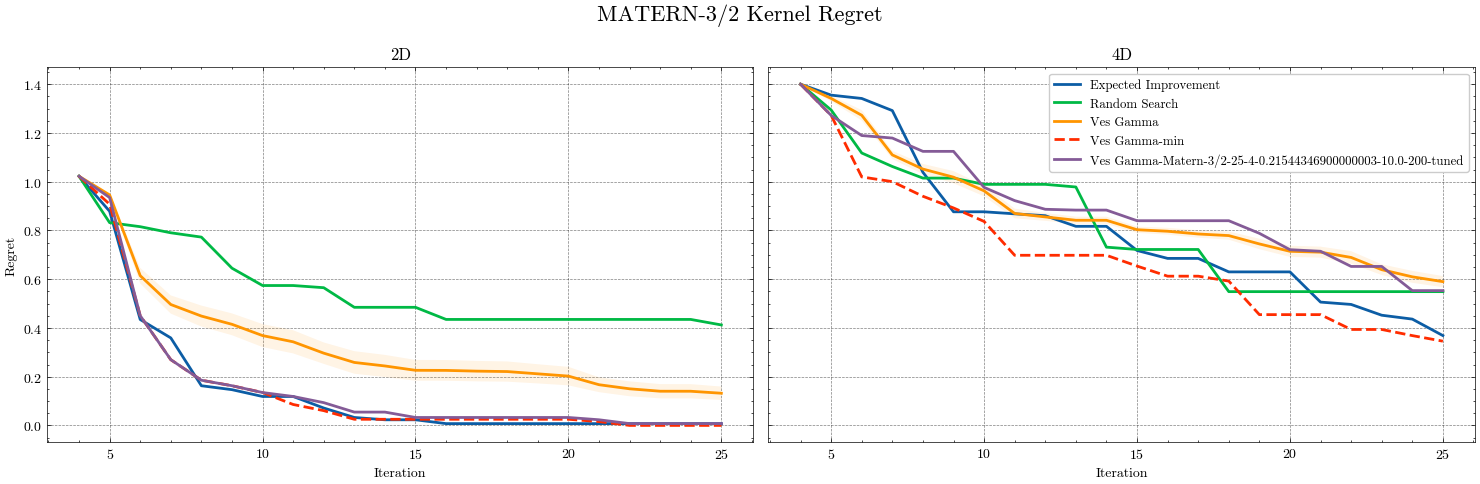

/Users/tomp/work/mes/paper_plots/benchmark-matern-5_2.png


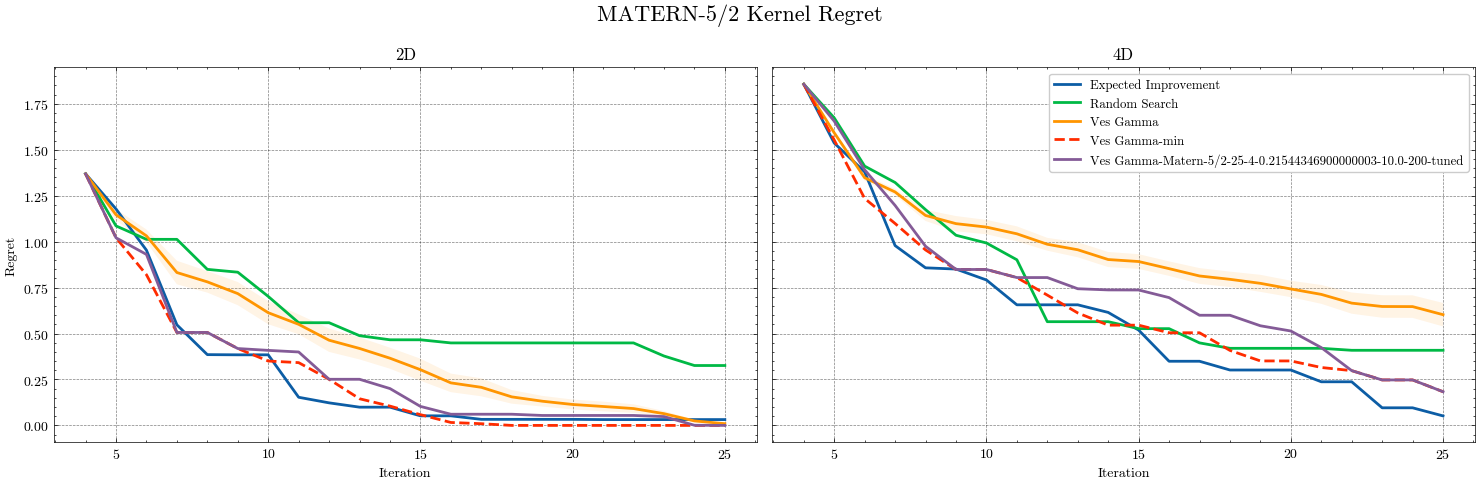

In [ ]:
plt.style.use(['science', 'grid', 'no-latex'])
def _plot_single(ax, data, n_dim, debug=False):
    idxs = data.index.droplevel("steps").unique()
    """Plot regret data for a single dimension on the given axis"""
    for acq_func in idxs:
        # print(acq_func, idxs.names)
        # acq_data = data.xs(acq_func, level=idxs.names)
        if isinstance(acq_func, tuple):
            acq_data = data.xs(acq_func, level=idxs.names)
            label = '-'.join(map(str, acq_func))
        else:
            acq_data = data.xs(acq_func, level=idxs.names[0])
            label = acq_func
        steps = acq_data.index
        label = label.replace('_', ' ').title()
        if debug:
            label += "-tuned"
        ax.plot(steps, acq_data['mean'],
                label=label, linewidth=2)

        # Add confidence bands
        standard_error = acq_data['std'] / np.sqrt(acq_data['count'])
        ax.fill_between(steps,
                        acq_data['mean'] - standard_error,
                        acq_data['mean'] + standard_error,
                        alpha=0.1)

        if acq_func == "ves_gamma" and not debug:
            ax.plot(steps, acq_data['min'], '--',
                    label=label.replace('_', ' ').title() + "-min", linewidth=2)


    ax.set_xlabel('Iteration')
    ax.set_title(f'{n_dim}D')
    # ax.grid(True, alpha=0.3) # use style instead

def plot_kernel(kernel_type, kernel_data):
    """Plot regret comparison for a specific kernel type with subplots for each dimension"""
    n_dims = kernel_data.index.get_level_values('n_dim').unique()

    fig, axes = plt.subplots(1, len(n_dims), figsize=(15, 5), sharey=True)
    if len(n_dims) == 1:
        axes = [axes]

    for i, n_dim in enumerate(n_dims):
        data = kernel_data.loc[n_dim]
        _plot_single(axes[i], data, n_dim)

        if i == 0:
            axes[i].set_ylabel('Regret')

        tuned_df = df.query("acq_func == 'ves_gamma' and lr == @lr_min and wd == @wd_min and kernel_type == @kernel_type and n_dim == @n_dim")
        xfm = tuned_df.groupby([c for c in tuned_df.columns if c != 'regret']).regret.agg(["mean", "count", "std"])
        _plot_single(axes[i], xfm, n_dim, debug=True)

    axes[-1].legend(loc='upper right', fontsize=9.2) # to put outside the plot: bbox_to_anchor=(1.05, 1),
    fig.suptitle(f'{kernel_type.upper()} Kernel Regret', fontsize=16)
    plt.tight_layout()
    print(SAVE_DIR / f"benchmark-{kernel_type.replace('/', '_')}.png")
    fig.savefig(SAVE_DIR / f"benchmark-{kernel_type.replace('/', '_')}.png", dpi=300)
    plt.show()

for kernel_type in regret_df.index.get_level_values('kernel_type').unique():
    kernel_data = regret_df.loc[kernel_type]
    plot_kernel(kernel_type, kernel_data)